# Import Libraries

In [2]:
!pip install xgboost shap lime matplotlib seaborn scikit-learn pandas numpy

# Load Dataset

In [3]:
import numpy as np
import pandas as pd

np.random.seed(123)

# Number of samples
N = 3000  

# Income distribution (realistic)
income = np.random.lognormal(mean=10.6, sigma=0.35, size=N)
income = income.clip(25000, 180000)

# Debt-to-income ratio
dti = np.random.beta(2, 5, size=N) * 0.7   # 0–0.7 range

# Credit history length (years)
credit_history = np.random.normal(7, 3, N).clip(0.5, 25)

# Number of delinquencies (Poisson + cap)
delinquencies = np.random.poisson(1.2, N)
delinquencies = np.clip(delinquencies, 0, 8)

# Revolving utilization
revolving_utilization = np.random.beta(2.5, 3, N)
revolving_utilization = revolving_utilization * 0.95  # 0–0.95

# Optional extra variables to improve model quality
open_accounts = np.random.randint(1, 14, N)
credit_card_limit = np.random.normal(12000, 5000, N).clip(1000, 30000)


# ---- Risk function that produces realistic default behavior ----
base_risk = (
    0.30 * dti +
    0.22 * revolving_utilization +
    0.18 * (delinquencies / 8) -
    0.20 * (income / 180000) -
    0.15 * (credit_history / 25)
)

# Add interactions (real world effects)
interaction_risk = (
    0.20 * (revolving_utilization * dti) +
    0.10 * (delinquencies * (1 / (credit_history + 1)))
)

# Final probability with noise
risk_prob = base_risk + interaction_risk + np.random.normal(0, 0.04, N)

# Convert to binary default
default = (risk_prob > 0.32).astype(int)


# ---- Build the final dataset ----
df = pd.DataFrame({
    "income": income.round(2),
    "dti": dti.round(3),
    "credit_history": credit_history.round(2),
    "delinquencies": delinquencies,
    "revolving_utilization": revolving_utilization.round(3),
    "open_accounts": open_accounts,
    "credit_card_limit": credit_card_limit.round(2),
    "default": default
})

# Show sample
df.head(10)


,income,dti,credit_history,delinquencies,revolving_utilization,open_accounts,credit_card_limit,default
0,27447.47,0.111,10.48,5,0.218,11,8977.97,0
1,56901.15,0.369,5.84,2,0.398,9,9238.06,0
2,44313.40,0.422,8.09,1,0.451,10,20914.49,0
3,25000.00,0.106,10.51,1,0.374,8,12071.00,0
4,32777.25,0.301,5.88,1,0.518,11,10646.10,0
5,71539.34,0.352,5.97,0,0.199,9,15133.43,0
6,25000.00,0.242,8.53,1,0.343,9,17785.09,0
7,34540.25,0.131,10.04,1,0.224,7,7195.88,0
8,62509.74,0.220,8.17,1,0.504,8,5698.23,0
9,29632.91,0.123,3.44,1,0.320,6,17497.11,0


# Train/Test Split

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop("default", axis=1)
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((2250, 7), (750, 7))

# Train XGBoost Model

In [7]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# Evaluation Metrics

In [9]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("AUC:", auc)
print("Precision:", precision)
print("Recall:", recall)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

AUC: 0.979624163006696
Precision: 0.6153846153846154
Recall: 0.42105263157894735

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       731
           1       0.62      0.42      0.50        19

    accuracy                           0.98       750
   macro avg       0.80      0.71      0.74       750
weighted avg       0.98      0.98      0.98       750



# Global SHAP Analysis

ExactExplainer explainer: 751it [00:48, 15.57it/s]                                                                     
C:\Users\ANUPRIYA\AppData\Local\Temp\ipykernel_27904\735379796.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)


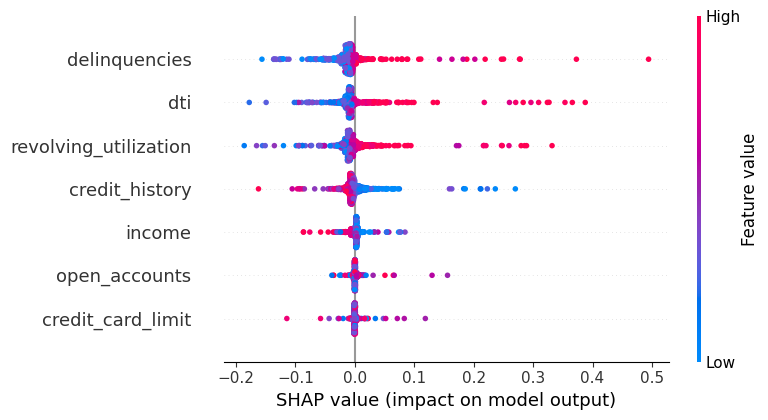

In [13]:
import shap
shap.initjs()

# Use model.predict as a callable
explainer = shap.Explainer(model.predict, X_train)

# Compute SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)

C:\Users\ANUPRIYA\AppData\Local\Temp\ipykernel_27904\1655944244.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


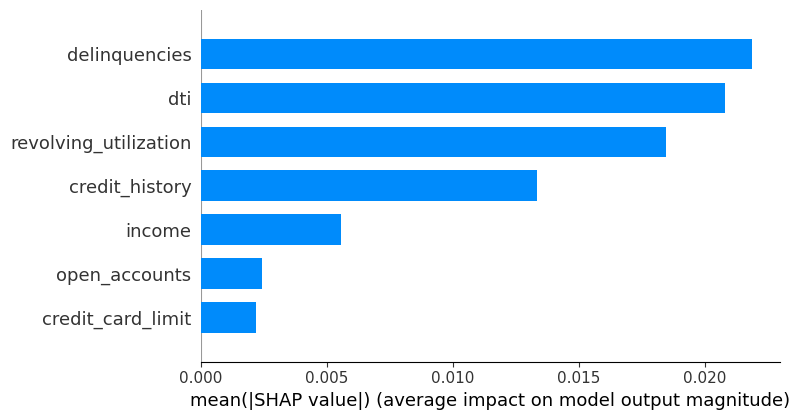

In [14]:
#SHAP Bar Plot (feature importance)
shap.summary_plot(
    shap_values.values, 
    X_test, 
    feature_names=X_test.columns, 
    plot_type="bar"
)


In [15]:
#Local SHAP Explanations (3–5 customer profiles)
# Find top 5 highest predicted default customers
high_risk_indices = y_pred_prob.argsort()[-5:]
high_risk_indices


array([471, 270,  90, 385,  81])

# Use the SHAP values object directly



SHAP Force Plot for customer index 471


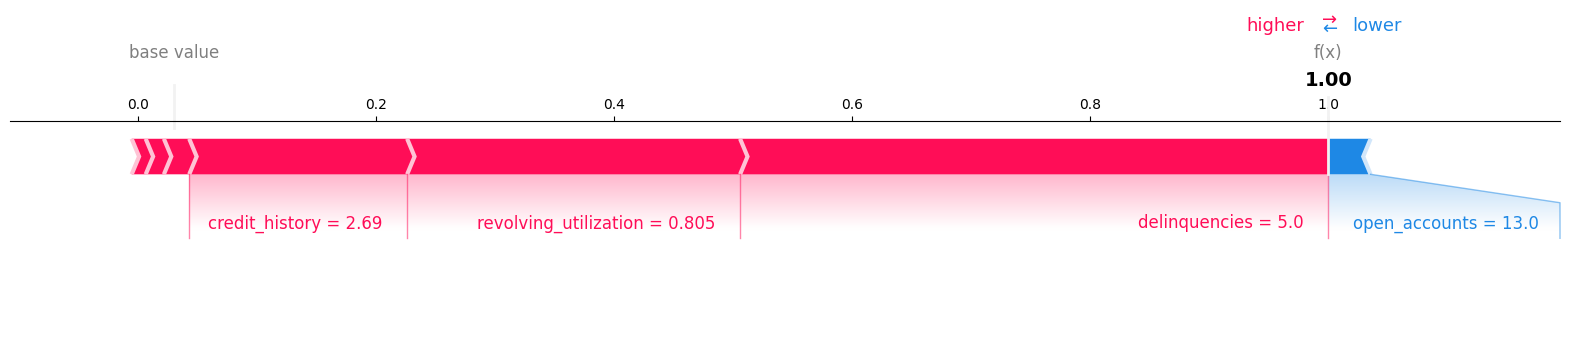


SHAP Force Plot for customer index 270


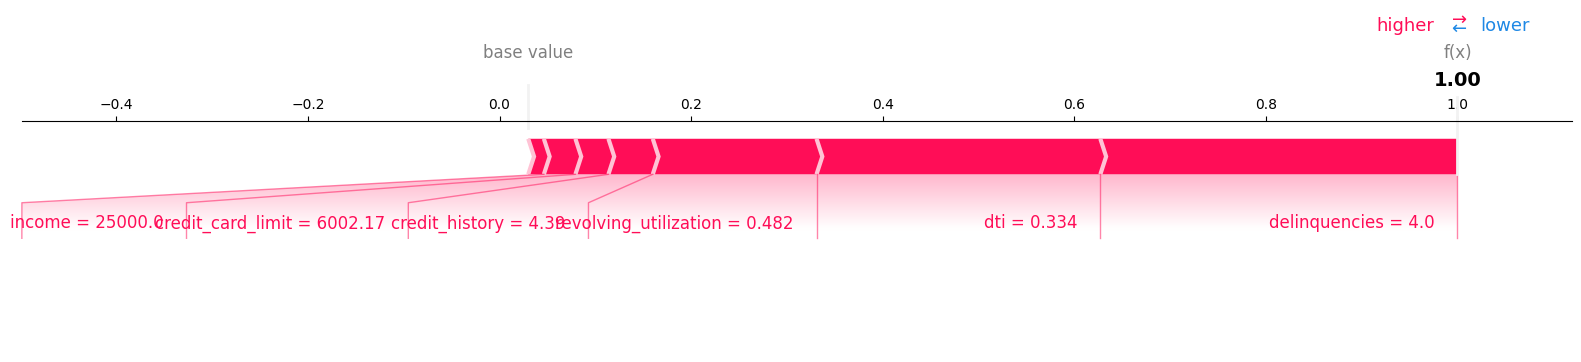


SHAP Force Plot for customer index 90


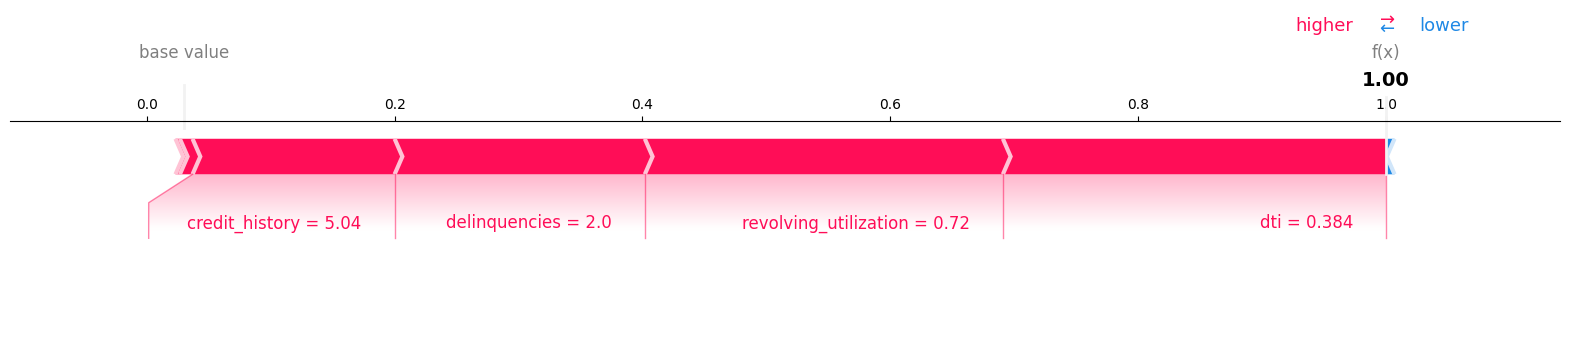


SHAP Force Plot for customer index 385


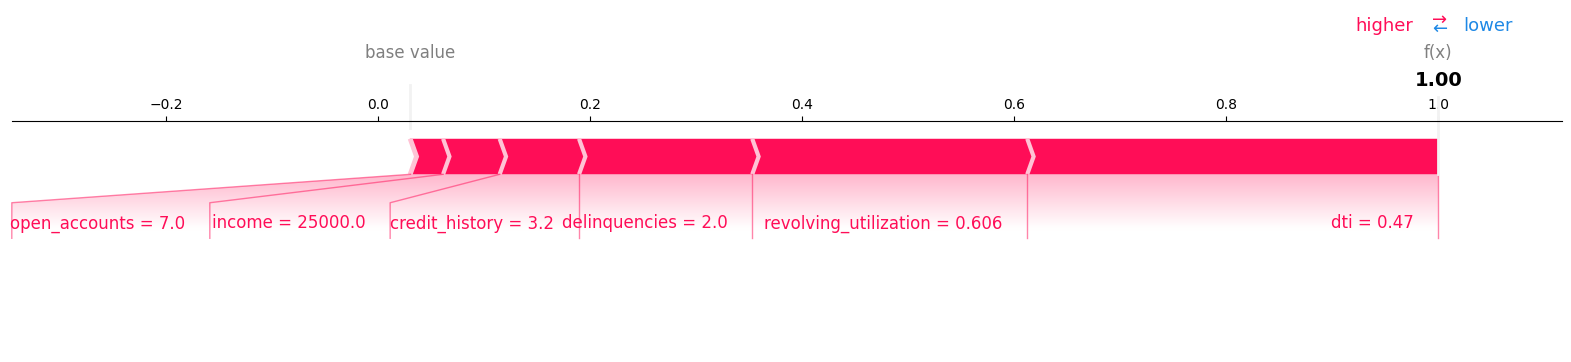


SHAP Force Plot for customer index 81


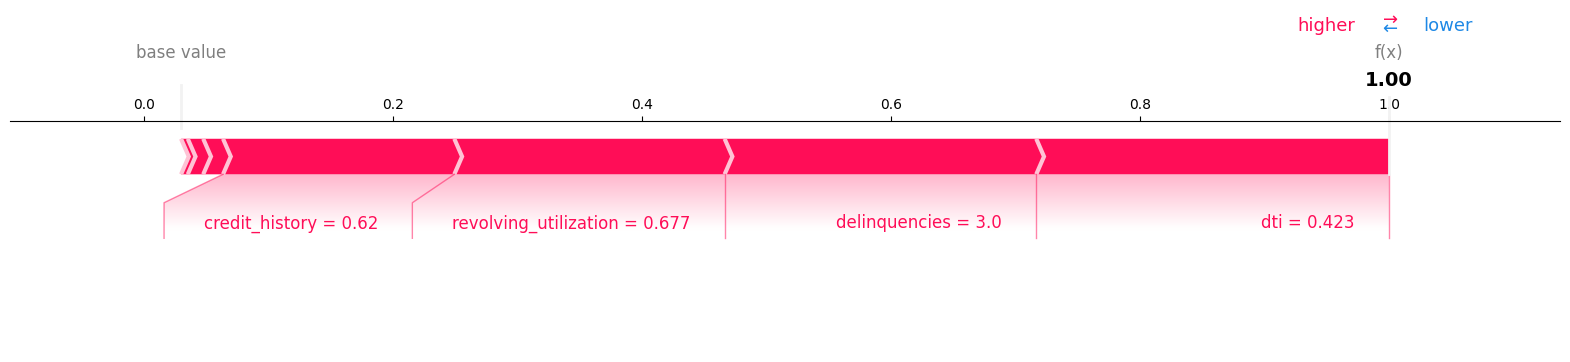

In [17]:
base_value = shap_values.base_values  # base values per row

for idx in high_risk_indices:
    print(f"\nSHAP Force Plot for customer index {idx}")
    
    shap.force_plot(
        base_value[idx],
        shap_values.values[idx],
        X_test.iloc[idx],
        matplotlib=True
    )


In [19]:
#Local SHAP (3 Customers)
top_risk_idx = np.argsort(y_pred_prob)[-3:]
top_risk_idx

array([ 90, 385,  81])

# SHAP force plots for selected high-risk customers


Force plot for customer index 90


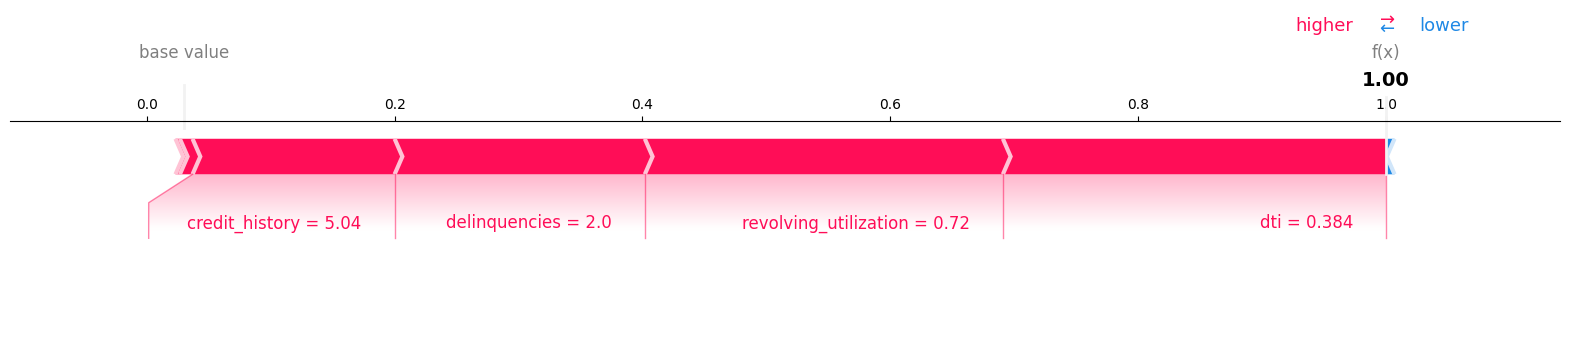


Force plot for customer index 385


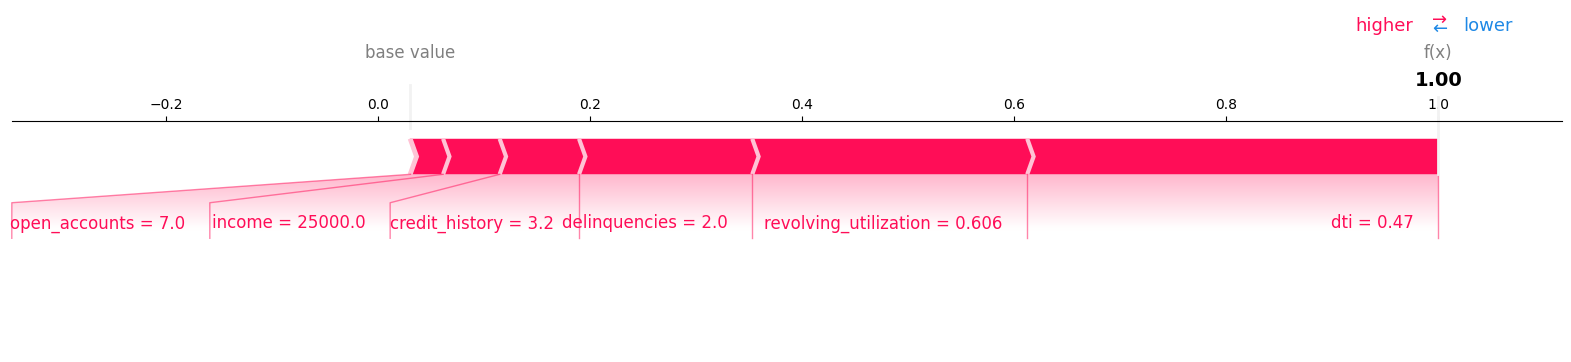


Force plot for customer index 81


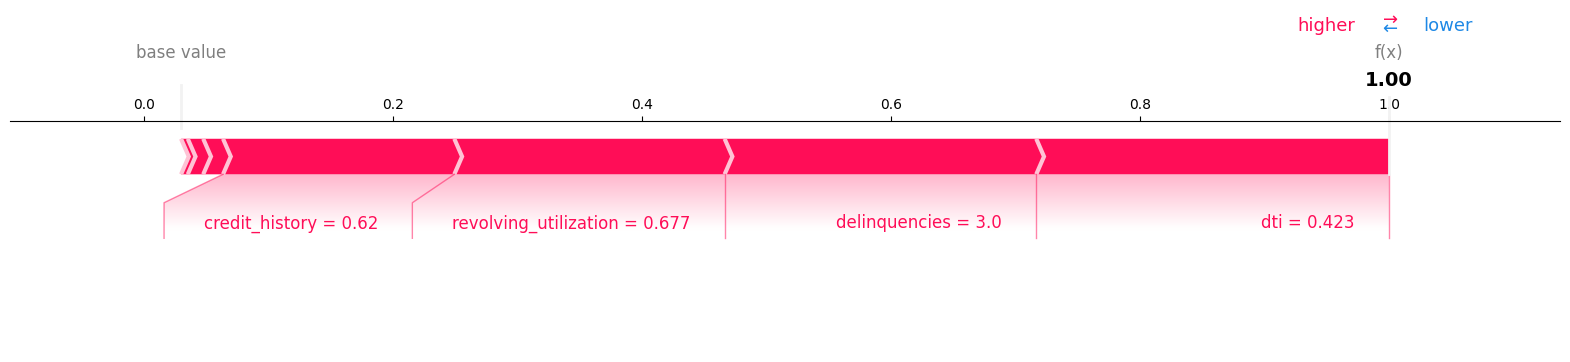

In [21]:

for idx in top_risk_idx:
    print(f"\nForce plot for customer index {idx}")

    shap.force_plot(
        base_value = shap_values.base_values[idx],
        shap_values = shap_values.values[idx],
        features = X_test.iloc[idx],
        matplotlib=True
    )

# LIME Local Explanations

In [23]:
!pip install lime

In [24]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

In [26]:
#Create LIME Explainer (correct version)
lime_exp = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=["No Default", "Default"],
    mode="classification"
)

In [27]:
#Generate LIME explanations for the same high-risk customers
for idx in top_risk_idx:
    print(f"\nLIME Explanation for customer index {idx}:\n")

    exp = lime_exp.explain_instance(
        data_row=X_test.iloc[idx].values,
        predict_fn=model.predict_proba,
        num_features=10
    )

    print(exp.as_list())



LIME Explanation for customer index 90:

[('dti > 0.27', 0.05409596879377641), ('revolving_utilization > 0.56', 0.05070370561218777), ('1.00 < delinquencies <= 2.00', 0.02662762237327647), ('open_accounts > 10.00', 0.003987507499267869), ('4.95 < credit_history <= 7.08', -0.0035452087656765493), ('32095.94 < income <= 40477.13', 0.0021357303027285746), ('credit_card_limit > 15310.91', 0.00190611988398047)]

LIME Explanation for customer index 385:

[('dti > 0.27', 0.060020208511282376), ('revolving_utilization > 0.56', 0.05637256865141097), ('credit_history <= 4.95', 0.04030792792406938), ('1.00 < delinquencies <= 2.00', 0.02618806749085426), ('income <= 32095.94', 0.005881787900113774), ('4.00 < open_accounts <= 7.00', -0.0033042143000554525), ('credit_card_limit > 15310.91', -0.0022521460815736805)]

LIME Explanation for customer index 81:

[('delinquencies > 2.00', 0.07282415301820218), ('dti > 0.27', 0.07141428545658521), ('revolving_utilization > 0.56', 0.05807796727839759), ('cr

# Generate Deliverables

In [29]:
import json

metrics = {
    "AUC": float(auc),
    "Precision": float(precision),
    "Recall": float(recall)
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)


In [30]:
with open("classification_report.txt", "w") as f:
    f.write(classification_report(y_test, y_pred))

In [31]:
summary = """
GLOBAL FINDINGS (SHAP):
- DTI, revolving utilization, & delinquencies increase default risk.
- High income and long credit history reduce default risk.

LOCAL FINDINGS (SHAP & LIME):
- Both methods consistently identify DTI & utilization as top contributors.
- LIME is easier to interpret locally; SHAP is more consistent globally.

POLICY RECOMMENDATIONS:
1. Avoid approving loans with DTI > 45%.
2. Flag customers with 2+ delinquencies for manual review.
3. Encourage utilization < 60%.
4. Prefer customers with long credit histories.
5. Use income stability as a compensating factor.
"""

with open("final_report_summary.txt", "w") as f:
    f.write(summary)
